In [ ]:
import pandas as pd
import numpy as np


# Посты

## Чтение данныех о постах


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ITMO/MLSys/posts4.09.csv',sep=',', index_col='id')
df.content = df.content.fillna('')
df.comments_count = df.comments_count.fillna(0)
df.drop(df.loc[df.content == ''].index, inplace=True)
df.shape
# df.dropna(inplace=True)

(21218, 7)

In [ ]:
df.content = df.content.fillna('')
df.comments_count = df.comments_count.fillna(0)

In [ ]:
df.drop(df.loc[df.content == ''].index, inplace=True)

In [ ]:
df.columns

Index(['#', 'id_channel', 'channel_id', 'comments_count', 'content',
       'is_forwarded', 'forwarded_from', 'len_text'],
      dtype='object')

<Axes: >

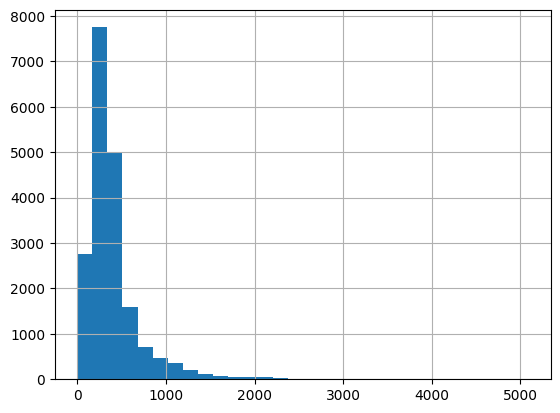

In [ ]:
df['len_text'] = df['content'].apply(len)
df.len_text.hist(bins=30)

In [ ]:
def max_len_word(text):
    words = text.split()
    lens = [len(word) for word in words]
    i = np.argmax(lens)
    return words[i]

In [ ]:
df['longest_word'] = ''
df.loc[df.len_text > 5000, 'longest_word'] = df.loc[df.len_text > 5000, 'content'].apply(max_len_word)

In [ ]:
df.loc[df.len_text > 5000, [ 'content','len_text','longest_word']]

content  len_text  \
id                                                                   
17062  Привет! Меня зовут Валентин, но в сети меня лу...      5089   

                                            longest_word  
id                                                        
17062  Max](https://market.yandex.ru/product--smartfo...

## Предобработка данных

In [ ]:
pip install catboost > None

In [ ]:
pip install pymorphy2 > None

In [ ]:
from catboost.text_processing import Tokenizer
from pymorphy2 import MorphAnalyzer
from urllib.parse import urlparse
from regex import sub, match, findall


class Redactor:
    def __init__(self):
        self.morph = MorphAnalyzer()


    def is_urls(self):
        for site in set(findall("(?P<url>https?://[^\s]+)", text)):
            try:
                new_site = urlparse(site).netloc
            except:
                continue
                # print(text, '\n', site)
            text = text.replace(site, new_site)

    def transform(self, text: str) -> str:
        """
        it is used to change the text: deleting stop words, replacing synonyms, lemming, replacing with a template
        :param text:
        :return: str:text
        """
        # Если не строка, вернуть строку нан
        if type(text) != type(''):
            return ''

        for site in set(findall("(?P<url>https?://[^\s]+)", text)):
            try:
                new_site = urlparse(site).netloc
            except:
                continue

            # print(text, '\n', site)
            text = text.replace(site, new_site)

        # лист слов текста в нижнем регистре
        word_list = Tokenizer(lowercasing=True,
                              separator_type='BySense',
                              languages=['Russian', 'English'],
                              ).tokenize(text)

        for ind, word in enumerate(word_list):

            if len(word) > 50:
                word_list[ind] = ''
                continue

            # граммемы для слова- Фамилия, Число и т.д.
            tags = self.morph.parse(word)[0].tag
            # слово в начальной форме
            norm_form = self.morph.parse(word)[0].normal_form  # строка - в начальной форме слова
            word_list[ind] = norm_form

            # замена имен, фам, отч, локации на шаблон
            if 'Name' in tags:
                word_list[ind] = 'нимя'
            elif 'Surn' in tags:
                word_list[ind] = 'нфамилия'  # Убираем фам
            elif 'Patr' in tags:
                word_list[ind] = 'нотчество'  # Убираем отч
            elif 'Geox' in tags:
                word_list[ind] = 'нместо'  # Убираем локации


        # word_list = [i for i in word_list if i != '']
        return ' '.join([i for i in word_list if i != ''])


In [ ]:
red = Redactor()
red.transform('Добрый день! Михаил \r\nУ клиента с договором ИМ123906.. 1275531907, 127.194.00.99, kandryukov.m@cdek.ru, {}, SD-506099, https://colab.research.google.com/drive/1zfr8BmEuXHqIi8OBeldy85i5yS5fNKSn#scroll')

'добрый день нимя у клиент с договор им123906 1275531907 127.194 00.99 kandryukov m cdek ru sd 506099 colab research google com'

In [ ]:
pip install pandas jupyter pandarallel requests tqdm

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.4 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16672 sha256=7e34d01e4d7d1770b06f32b63d721683453694c9323238d2ba89d394ad104f4c
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel


In [ ]:
import pandas as pd
import requests

from tqdm import tqdm
tqdm.pandas()

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=4)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
valid_signs = set('•@:#$%^&*()~qwertyuiop[]asdfghjkl;zxcvbnm,./1234567890-=_—+йцукенгшщзхъфывапролджёэячсмитьбю!^?… \\ \n \r \t >< \xa0 ← → |{}"–©№»« \u200b ∙ ’“”'+"'")
empty_set = set([])

df['valid_lang'] = df['content'].parallel_apply(lambda text: set(text.lower()) - valid_signs == empty_set)

In [ ]:
df.valid_lang.value_counts()

True     17197
False     2041
Name: valid_lang, dtype: int64

In [ ]:
df = df.loc[df.valid_lang == True] # del china language
df

#  id_channel  channel_id  comments_count  \
id                                                     
1          1       42326           1             0.0   
2          2       42325           1             0.0   
3          3       42324           1             0.0   
4          4       42323           1             0.0   
5          5       42322           1             0.0   
...      ...         ...         ...             ...   
21209  21209          62          64             0.0   
21214  21214           5          66             0.0   
21215  21215           4          66             0.0   
21216  21216           3          66             0.0   
21217  21217           2          66             0.0   

                                                 content  is_forwarded  \
id                                                                       
1      Кролеги, не расслабляйте булки. Новый год ПОЗА...         False   
2      [iXBT.games поздравляет с наступающим Новым го...         False   
3      [Создатель Vampire Survivors сам не понимает, ...         False   
4      [Вышло демо польского ремейка Fallout 2 в стил...         False   
5      [Фанаты Stardew Valley ответили благодарностью...         False   
...                                                  ...           ...   
21209  Ловите обещанный рассказ о том, как выглядел п...         False   
21214                       https://youtu.be/pzlYw5VmjIo         False   
21215                       https://youtu.be/h432K9sRidg         False   
21216                       https://youtu.be/0JgBitNsiUw         False   
21217                       https://youtu.be/feKexXt3p0E         False   

       forwarded_from  len_text longest_word  valid_lang  
id                                                        
1                 NaN        73                     True  
2                 NaN       460                     True  
3                 NaN       338                     True  
4                 NaN       346                     True  
5                 NaN       358                     True  
...               ...       ...          ...         ...  
21209             NaN       187                     True  
21214             NaN        28                     True  
21215             NaN        28                     True  
21216             NaN        28                     True  
21217             NaN        28                     True  

[17197 rows x 10 columns]

In [ ]:
df["pre_desc"] = df['content'].parallel_apply(red.transform)


<ipython-input-54-d6a6c750b5d7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pre_desc"] = df['content'].parallel_apply(red.transform)


In [ ]:
df

#  id_channel  channel_id  comments_count  \
id                                                     
1          1       42326           1             0.0   
2          2       42325           1             0.0   
3          3       42324           1             0.0   
4          4       42323           1             0.0   
5          5       42322           1             0.0   
...      ...         ...         ...             ...   
21209  21209          62          64             0.0   
21214  21214           5          66             0.0   
21215  21215           4          66             0.0   
21216  21216           3          66             0.0   
21217  21217           2          66             0.0   

                                                 content  is_forwarded  \
id                                                                       
1      Кролеги, не расслабляйте булки. Новый год ПОЗА...         False   
2      [iXBT.games поздравляет с наступающим Новым го...         False   
3      [Создатель Vampire Survivors сам не понимает, ...         False   
4      [Вышло демо польского ремейка Fallout 2 в стил...         False   
5      [Фанаты Stardew Valley ответили благодарностью...         False   
...                                                  ...           ...   
21209  Ловите обещанный рассказ о том, как выглядел п...         False   
21214                       https://youtu.be/pzlYw5VmjIo         False   
21215                       https://youtu.be/h432K9sRidg         False   
21216                       https://youtu.be/0JgBitNsiUw         False   
21217                       https://youtu.be/feKexXt3p0E         False   

       forwarded_from  len_text longest_word  valid_lang            typ  \
id                                                                        
1                 NaN        73                     True  <class 'str'>   
2                 NaN       460                     True  <class 'str'>   
3                 NaN       338                     True  <class 'str'>   
4                 NaN       346                     True  <class 'str'>   
5                 NaN       358                     True  <class 'str'>   
...               ...       ...          ...         ...            ...   
21209             NaN       187                     True  <class 'str'>   
21214             NaN        28                     True  <class 'str'>   
21215             NaN        28                     True  <class 'str'>   
21216             NaN        28                     True  <class 'str'>   
21217             NaN        28                     True  <class 'str'>   

                                                pre_desc  \
id                                                         
1      нимя не расслаблять булка новый год позади нач...   
2      ixbt games поздравлять с наступать новый год с...   
3      создатель vampire survivors сам не понимать по...   
4      выйти дть польский ремейк fallout 2 в стиль do...   
5      фанат stardew valley ответить благодарность на...   
...                                                  ...   
21209  ловить обещать рассказ о тот как выглядеть пут...   
21214                                           youtu be   
21215                                           youtu be   
21216                                           youtu be   
21217                                           youtu be   

                                                    text  len_pre_text  
id                                                                      
1      кролеги, не расслабляйте булки. новый год поза...            73  
2      [ixbt.games поздравляет с наступающим новым го...           376  
3      [создатель vampire survivors сам не понимает, ...           231  
4      [вышло демо польского ремейка fallout 2 в стил...           242  
5      [фанаты stardew valley ответили благодарностью...           246  
...                                                

In [ ]:
df['text'] = df['pre_desc']

<ipython-input-35-9cd8e39f84a3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['pre_desc']


<ipython-input-36-d18b45fe6f31>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['len_pre_text'] = df['text'].apply(len)


<Axes: >

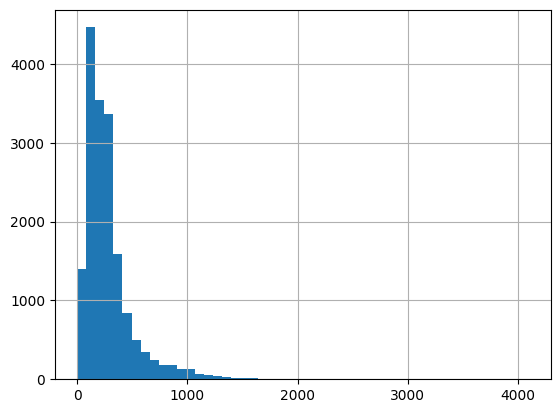

In [ ]:
df['len_pre_text'] = df['text'].apply(len)
# df = df.loc[df.len_pre_text < df.len_pre_text.quantile(0.99)]
df['len_pre_text'].hist(bins=50)

In [ ]:
df.columns

Index(['#', 'id_channel', 'channel_id', 'comments_count', 'content',
       'is_forwarded', 'forwarded_from', 'len_text', 'longest_word',
       'valid_lang', 'typ', 'pre_desc', 'text', 'len_pre_text'],
      dtype='object')

In [ ]:
df[['id_channel', 'channel_id', 'content',   'pre_desc']].to_csv('/content/drive/MyDrive/ITMO/MLSys/pre_posts.csv', sep=';')

# Лента новости

## Чтение данных


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import pandas as pd

# Путь к ZIP-архиву
zip_path = '/content/drive/MyDrive/ITMO/MLSys/archive.zip'

# Путь к CSV-файлу внутри архива
csv_file_in_zip = 'lenta-ru-news.csv'

In [ ]:
with zipfile.ZipFile(zip_path, 'r') as archive:
    # Чтение CSV-файла в архиве
    with archive.open(csv_file_in_zip) as file:
        # Чтение данных в DataFrame с использованием Pandas
        df = pd.read_csv(file)
df
# df.dropna(inplace=True)

<ipython-input-4-ea615a459534>:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


url  \
0        https://lenta.ru/news/1914/09/16/hungarnn/   
1       https://lenta.ru/news/1914/09/16/lermontov/   
2       https://lenta.ru/news/1914/09/17/nesteroff/   
3        https://lenta.ru/news/1914/09/17/bulldogn/   
4            https://lenta.ru/news/1914/09/18/zver/   
...                                             ...   
800970      https://lenta.ru/news/2019/12/14/shnur/   
800971       https://lenta.ru/news/2019/12/14/dolg/   
800972  https://lenta.ru/news/2019/12/14/dark_euro/   
800973      https://lenta.ru/news/2019/12/14/meteo/   
800974      https://lenta.ru/news/2019/12/14/olimp/   

                                                    title  \
0       1914. Русские войска вступили в пределы Венгрии     
1       1914. Празднование столетия М.Ю. Лермонтова от...   
2                                1914. Das ist Nesteroff!   
3                         1914. Бульдог-гонец под Льежем    
4                1914. Под Люблином пойман швабский зверь   
...                                                   ...   
800970          Шнуров раскритиковал Гагарину на «Голосе»   
800971  В России предложили изменить правила взыскания...   
800972          В России назвали «черную дату» для Европы   
800973        Россиянам пообещали аномально теплую погоду   
800974  В конкурсе прогнозов на АПЛ разыграют 100 тыся...   

                                                     text       topic  \
0       Бои у Сопоцкина и Друскеник закончились отступ...  Библиотека   
1       Министерство народного просвещения, в виду про...  Библиотека   
2       Штабс-капитан П. Н. Нестеров на днях, увидев в...  Библиотека   
3       Фотограф-корреспондент Daily Mirror рассказыва...  Библиотека   
4       Лица, приехавшие в Варшаву из Люблина, передаю...  Библиотека   
...                                                   ...         ...   
800970  Певец Сергей Шнуров раскритиковал свою коллегу...         NaN   
800971  Министерство юстиции России предложило изменит...         NaN   
800972  Испытание США ранее запрещенной Договором о ли...         NaN   
800973  В ближайшие дни в европейской части России пог...         NaN   
800974  Ведущие футбольные чемпионаты ушли на зимние к...         NaN   

                     tags        date  
0          Первая мировая  1914/09/16  
1          Первая мировая  1914/09/16  
2          Первая мировая  1914/09/17  
3          Первая мировая  1914/09/17  
4          Первая мировая  1914/09/18  
...                   ...         ...  
800970         ТВ и радио  2019/12/14  
800971                Все  2019/12/14  
800972           Политика  2019/12/14  
800973           Общество  2019/12/14  
800974  Английский футбол  2019/12/14  

[800975 rows x 6 columns]

In [ ]:
df.tags.value_counts().head(40)

Все                     453762
Политика                 40716
Общество                 35202
Украина                  22523
Происшествия             19825
Госэкономика             15476
Футбол                   15239
Кино                     10720
Интернет                  9319
Бизнес                    9146
Следствие и суд           9133
Наука                     7932
Музыка                    7406
Люди                      6567
Квартира                  5180
Преступность              5057
ТВ и радио                4391
Космос                    4311
Конфликты                 3798
События                   3664
Coцсети                   3635
Бокс и ММА                3549
Регионы                   3516
Летние виды               3265
Деловой климат            3254
Явления                   3216
Криминал                  3209
Звери                     3063
Рынки                     2834
Стиль                     2566
Мир                       2566
Оружие                    2457
Город   

In [ ]:
df.text = df.text.fillna('')
df.title = df.title.fillna('')
df.text = df.text + ' ' + df.title

<Axes: >

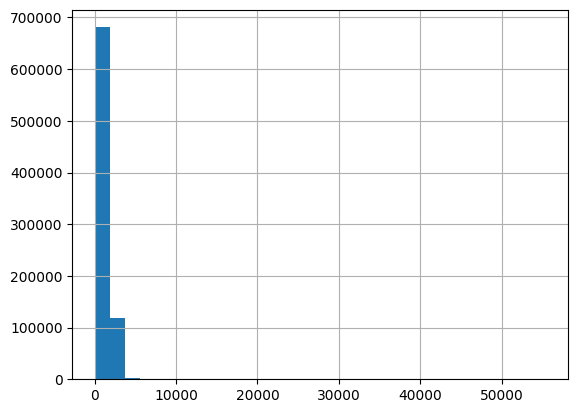

In [ ]:
df['len_text'] = df['text'].apply(len)
df.len_text.hist(bins=30)

<Axes: >

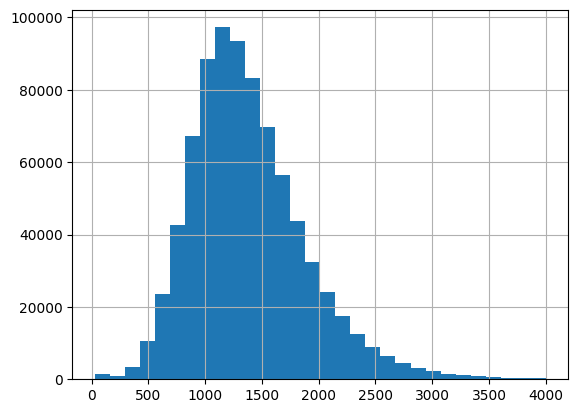

In [ ]:
df.drop(df[df.len_text > 4000].index, inplace=True)
df.len_text.hist(bins=30)

## Предобработка

In [ ]:
pip install pandarallel > None

In [ ]:
import pandas as pd
import requests

from tqdm import tqdm
tqdm.pandas()

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=8)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
df = df.sample(frac=1).sample(300_000)

In [ ]:
valid_signs = set('•@:#$%^&*()~qwertyuiop[]asdfghjkl;zxcvbnm,./1234567890-=_—+йцукенгшщзхъфывапролджёэячсмитьбю!^?… \\ \n \r \t >< \xa0 ← → |{}"–©№»« \u200b ∙ ’“”'+"'")
empty_set = set([])

df['valid_lang'] = df['text'].parallel_apply(lambda text: set(text.lower()) - valid_signs == empty_set)


In [ ]:
df.valid_lang.value_counts()

In [ ]:
df = df.loc[df.valid_lang == True] # del china language
df

In [ ]:
df["pre_desc"] = df['text'].parallel_apply(red.transform)


In [ ]:
df.to_csv('/content/drive/MyDrive/ITMO/MLSys/pre_news.csv', sep=';')

# Обченние

In [ ]:
df

url  \
516486              https://lenta.ru/news/2014/09/11/mid/   
773993          https://lenta.ru/news/2019/08/01/notdead/   
433564          https://lenta.ru/news/2012/09/03/billion/   
606907  https://lenta.ru/news/2016/07/13/nadezhdaklisc...   
732111  https://lenta.ru/news/2018/10/22/foreign_capital/   
...                                                   ...   
428571        https://lenta.ru/news/2012/07/21/interview/   
509802     https://lenta.ru/news/2014/07/08/cabavoltaire/   
683305        https://lenta.ru/news/2017/09/19/vanino_ga/   
420182            https://lenta.ru/news/2012/05/15/banks/   
598370      https://lenta.ru/news/2016/05/25/dowantvodka/   

                                                    title  \
516486  Москва отреагировала на внесение Савченко и Се...   
773993  «Покойник» проснулся от щекотки и испортил мог...   
433564  Восточная Германия потребовала от властей трил...   
606907  Мать Клишиной выразила уверенность в выступлен...   
732111           В России вознамерились ограничить Google   
...                                                   ...   
428571  "Новая газета" опубликовала отвергнутое "Извес...   
509802  Группа Cabaret Voltaire выступит впервые за 20...   
683305   В России впервые отобрали дальневосточный гектар   
420182    Moody's понизило рейтинги 26 итальянских банков   
598370  Савченко заявила о желании выпить пару литров ...   

                                                     text           topic  \
516486  В Москве не считают, что положения Минского пр...          Россия   
773993  Затянувшийся розыгрыш, в который оказались втя...             NaN   
433564  Власти Тюрингии заявили о необходимости инвест...             Мир   
606907  Российская прыгунья в длину Дарья Клишина на О...           Спорт   
732111  Группа депутатов Госдумы внесла на рассмотрени...  Интернет и СМИ   
...                                                   ...             ...   
428571  "Новая газета" 21 июля опубликовала интервью К...  Интернет и СМИ   
509802  Первое за 20 лет живое выступление классиков б...        Культура   
683305  Суд райцентра Ванино в Хабаровском крае лишил ...          Россия   
420182  Агентство Moody's в понедельник, 14 мая, пониз...       Экономика   
598370  Помилованная президентом России Владимиром Пут...     Бывший СССР   

                tags        date  len_text  
516486      Политика  2014/09/11      1483  
773993  Происшествия  2019/08/01      1416  
433564           Все  2012/09/03      1551  
606907           NaN  2016/07/13      1474  
732111      Интернет  2018/10/22      1921  
...              ...         ...       ...  
428571           Все  2012/07/21      2169  
509802        Музыка  2014/07/08      1185  
683305      Общество  2017/09/19      1740  
420182           Все  2012/05/15      1315  
598370       Украина  2016/05/25      1087  

[300000 rows x 7 columns]

## TF-idf

In [ ]:
df.dropna(inplace=True)

In [ ]:
train, validate, test = \
              np.split(df.sample(frac=1),
                       [int(.6*len(df)), int(.8*len(df))])


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2),
                            #  stop_words=stop_words,
                             max_features=40000,
                             min_df=50
                             )


X = vectorizer.fit_transform(train['text'])
X_val = vectorizer.transform(validate['text'])

### LogReg

In [ ]:
train.columns

Index(['url', 'title', 'text', 'topic', 'tags', 'date', 'len_text'], dtype='object')

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X, train.topic)
y_pred = clf.predict(X_val)
accuracy = accuracy_score(validate['topic'], y_pred)
accuracy

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8334363353746466

In [ ]:
posts = pd.read_csv('/content/drive/MyDrive/ITMO/MLSys/pre_posts.csv', sep=';')
posts

id  id_channel  channel_id  \
0          1       42326           1   
1          2       42325           1   
2          3       42324           1   
3          4       42323           1   
4          5       42322           1   
...      ...         ...         ...   
17192  21209          62          64   
17193  21214           5          66   
17194  21215           4          66   
17195  21216           3          66   
17196  21217           2          66   

                                                 content  \
0      Кролеги, не расслабляйте булки. Новый год ПОЗА...   
1      [iXBT.games поздравляет с наступающим Новым го...   
2      [Создатель Vampire Survivors сам не понимает, ...   
3      [Вышло демо польского ремейка Fallout 2 в стил...   
4      [Фанаты Stardew Valley ответили благодарностью...   
...                                                  ...   
17192  Ловите обещанный рассказ о том, как выглядел п...   
17193                       https://youtu.be/pzlYw5VmjIo   
17194                       https://youtu.be/h432K9sRidg   
17195                       https://youtu.be/0JgBitNsiUw   
17196                       https://youtu.be/feKexXt3p0E   

                                                pre_desc  
0      нимя не расслаблять булка новый год позади нач...  
1      ixbt games поздравлять с наступать новый год с...  
2      создатель vampire survivors сам не понимать по...  
3      выйти дть польский ремейк fallout 2 в стиль do...  
4      фанат stardew valley ответить благодарность на...  
...                                                  ...  
17192  ловить обещать рассказ о тот как выглядеть пут...  
17193                                           youtu be  
17194                                           youtu be  
17195                                           youtu be  
17196                                           youtu be  

[17197 rows x 5 columns]

In [ ]:
X_p = vectorizer.transform(posts.content)
posts['pred'] = clf.predict(X_p)

In [ ]:
posts

id  id_channel  channel_id  \
0          1       42326           1   
1          2       42325           1   
2          3       42324           1   
3          4       42323           1   
4          5       42322           1   
...      ...         ...         ...   
17192  21209          62          64   
17193  21214           5          66   
17194  21215           4          66   
17195  21216           3          66   
17196  21217           2          66   

                                                 content  \
0      Кролеги, не расслабляйте булки. Новый год ПОЗА...   
1      [iXBT.games поздравляет с наступающим Новым го...   
2      [Создатель Vampire Survivors сам не понимает, ...   
3      [Вышло демо польского ремейка Fallout 2 в стил...   
4      [Фанаты Stardew Valley ответили благодарностью...   
...                                                  ...   
17192  Ловите обещанный рассказ о том, как выглядел п...   
17193                       https://youtu.be/pzlYw5VmjIo   
17194                       https://youtu.be/h432K9sRidg   
17195                       https://youtu.be/0JgBitNsiUw   
17196                       https://youtu.be/feKexXt3p0E   

                                                pre_desc             pred  
0      нимя не расслаблять булка новый год позади нач...           Россия  
1      ixbt games поздравлять с наступать новый год с...  Наука и техника  
2      создатель vampire survivors сам не понимать по...  Наука и техника  
3      выйти дть польский ремейк fallout 2 в стиль do...   Интернет и СМИ  
4      фанат stardew valley ответить благодарность на...  Наука и техника  
...                                                  ...              ...  
17192  ловить обещать рассказ о тот как выглядеть пут...         Культура  
17193                                           youtu be              Мир  
17194                                           youtu be              Мир  
17195                                           youtu be              Мир  
17196                                           youtu be              Мир  

[17197 rows x 6 columns]

In [ ]:
preds = clf.predict_proba(X_p)

In [ ]:
pd.concat((posts, pd.DataFrame(preds, columns=clf.classes_)), axis=1).to_csv('/content/drive/MyDrive/ITMO/MLSys/pre_posts_pred.csv', sep=';')

In [ ]:
import matplotlib.pyplot as plt
posts.pred.hist(bins=posts.pred.unique().size)
plt.xticks(rotation=90)